# 영화리뷰 텍스트 감성분석하기

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성   

    데이터의 중복 제거
    NaN 결측치 제거
    한국어 토크나이저로 토큰화
    불용어(Stopwords) 제거
    사전word_to_index 구성
    텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train, y_train, X_test, y_test, word_to_index 리턴



In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True) #중복제거
    train_data = train_data.dropna(how = 'any') #제거로 인한 빈칸 지우기
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = [] 
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 : 문장을 분리시켜줌.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist() #행렬 연결
    counter = Counter(words)
    counter = counter.most_common(10000-4) #10000개 단어를 쌓는데 아래 4개 자리를 비우기 위해 -4
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):#워드리스트에서 워드를 숫자로 변화시켜주는것.
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))#데이터 리스트 지정
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
#위에서 만든 함수를 아래 데이터 형태로 쪼개줌
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
#load_data를 쪼겐 것

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공   

    데이터셋 내 문장 길이 분포
    적절한 최대 문장 길이 지정
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요. 

In [7]:
#vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [8]:
#vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [10]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 100000건
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
91/91 [==============================] - 1s 13ms/step - loss: 0.6929 - accuracy: 0.5034 - val_loss: 0.6921 - val_accuracy: 0.5122
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.6056 - accuracy: 0.6643 - val_loss: 0.4766 - val_accuracy: 0.8087
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.4068 - accuracy: 0.8395 - val_loss: 0.3944 - val_accuracy: 0.8324
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.3302 - accuracy: 0.8709 - val_loss: 0.3811 - val_accuracy: 0.8343
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.2994 - accuracy: 0.8851 - val_loss: 0.3953 - val_accuracy: 0.8367
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.2802 - accuracy: 0.8957 - val_loss: 0.3942 - val_accuracy: 0.8330
Epoch 7/20
91/91 [==============================] - 1s 9ms/step - loss: 0.2653 - accuracy: 0.9026 - val_loss: 0.4060 - val_accuracy: 0.8308
Epoch 8/20
91/91 [=

In [12]:
results = model.evaluate(X_test,  y_test, verbose=2) #테스트셋 평가

print(results)

1537/1537 - 3s - loss: 0.5489 - accuracy: 0.8134
[0.5489017367362976, 0.8133938312530518]


## 6) Loss, Accuracy 그래프 시각화

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


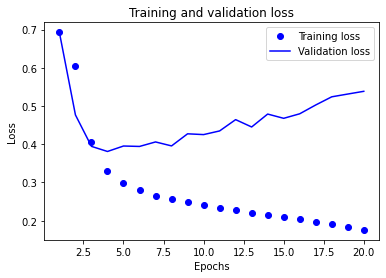

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

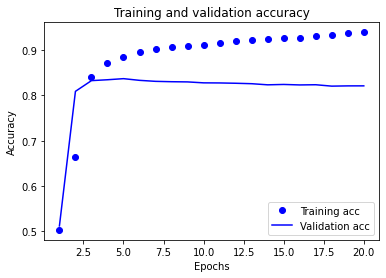

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['고양이']
vector

array([-0.07244774,  0.06766536, -0.01281397, -0.00610021, -0.04859131,
        0.01874262,  0.06987236,  0.04723222,  0.00569217, -0.03050797,
       -0.02211757, -0.0030581 ,  0.01961176,  0.01847284,  0.17721134,
       -0.02128544], dtype=float32)

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([-0.11054958,  0.06009573, -0.03714353,  0.07388075, -0.10120726,
        0.0695765 ,  0.09290231,  0.10785442, -0.10773189,  0.05384564,
        0.0357635 ,  0.0957559 ,  0.07800565, -0.11852548, -0.15742809,
       -0.12531315], dtype=float32)

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선